In [98]:
import sys
sys.path.insert(0, '..')

In [99]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [100]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [101]:
wid = 64
oversample = 2

nwavels = 10
npoly=2

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    'n8yj53vfq_cal.fits'

]

ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits"]

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    #"n43ca5fjq_cal.fits",
    #"n43ca5fkq_cal.fits",
    #"n43ca5flq_cal.fits",
    #"n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    #"n43ca5ffq_cal.fits",
    #"n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    #"n43c03dnq_cal.fits",
    #"n43c03doq_cal.fits",
    #"n43c03dpq_cal.fits",
    #"n43c03drq_cal.fits",
    #F108N
    #"n43c03dsq_cal.fits",
    #"n43c03duq_cal.fits",
    #"n43c03dvq_cal.fits",
    #"n43c03dwq_cal.fits",
]

ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    'n4be02nqq_cal.fits',
    'n4be02ntq_cal.fits',
    'n4be02nwq_cal.fits',
    'n4be02o0q_cal.fits',
]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

Filename: ../data/MAST_2025-03-06T11_35_52.340Z/HST/n4be02npq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     300   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.0
Filename: ../data/MAST_2025-03-06T11_35_52.340Z/HST/n4be02nsq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     300   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [102]:
for e in exposures_single:
    print(e.mjd*86400)

4384826639.485632
4384826770.4861765
4384826901.485856
4384827032.485536
4384826674.486272
4384826805.485951
4384826936.485632
4384827067.485312


In [103]:
data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()

print(files)


#exposures_single = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files][2:5]

['na2a12jmq_cal.fits', 'na2a12jnq_cal.fits', 'na2a12joq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jqq_cal.fits', 'na2a12jxq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k0q_cal.fits', 'na2a12k1q_cal.fits', 'na2a12k2q_cal.fits', 'na2a12k9q_cal.fits', 'na2a12kbq_cal.fits', 'na2a12kcq_cal.fits', 'na2a12kdq_cal.fits', 'na2a12keq_cal.fits', 'na2a12klq_cal.fits', 'na2a12knq_cal.fits', 'na2a12koq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kqq_cal.fits', 'na2a12kxq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l0q_cal.fits', 'na2a12l1q_cal.fits', 'na2a12l2q_cal.fits', 'na2a12lgq_cal.fits', 'na2a12liq_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lkq_cal.fits', 'na2a12llq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12luq_cal.fits', 'na2a12lvq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12lxq_cal.fits', 'na2a12m4q_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m7q_cal.fits', 'na2a12m8q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mgq_cal.fits', 'na2a12miq_cal.fits', 'na2a12mjq_cal.fits', 'na2a12mkq_cal.fits', 'na2a12mlq_cal.fits', 'na2a12ms

In [ ]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([6., 6.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [105]:
exp.fit.get_key(exp, "primary_distortion")

'global'

In [106]:
optics

NICMOSOptics(
  wf_npixels=512,
  diameter=2.4,
  layers={
    'CompoundAperture':
    CompoundAperture(
      normalise=True,
      transformation=CoordTransform(
        translation=None,
        rotation=f32[],
        compression=None,
        shear=None
      ),
      apertures={
        'main_aperture':
        HSTMainAperture(
          normalise=True,
          transformation=CoordTransform(
            translation=None,
            rotation=f32[],
            compression=None,
            shear=None
          ),
          apertures={
            'mirror':
            CircularAperture(
              normalise=False,
              transformation=None,
              occulting=False,
              softness=2.0,
              radius=1.2
            ),
            'spider':
            Spider(
              normalise=False,
              transformation=None,
              occulting=True,
              softness=2.0,
              width=0.026399999999999996,
              angles=f32[4

In [107]:
#plt.imshow(exposures_single[0].fit(model_single,exposures_single[0])**0.125)

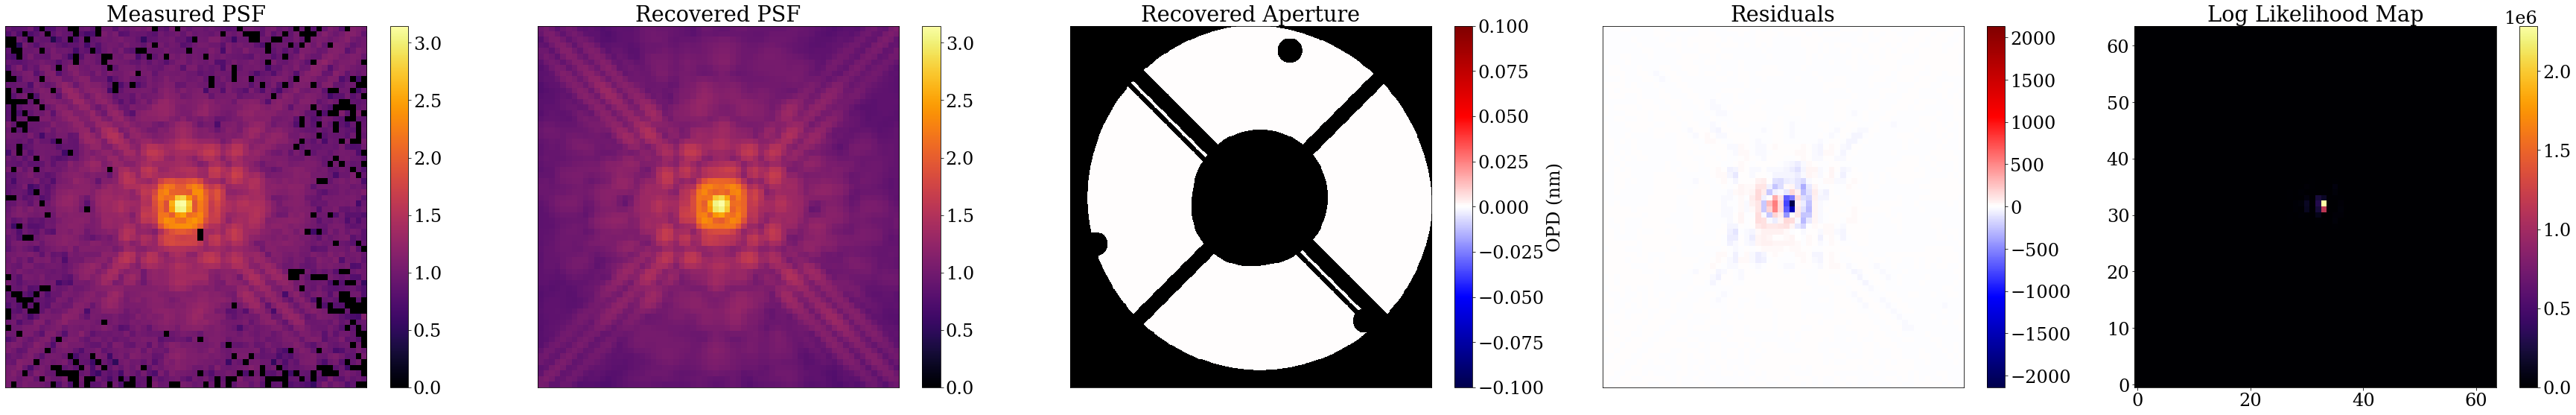

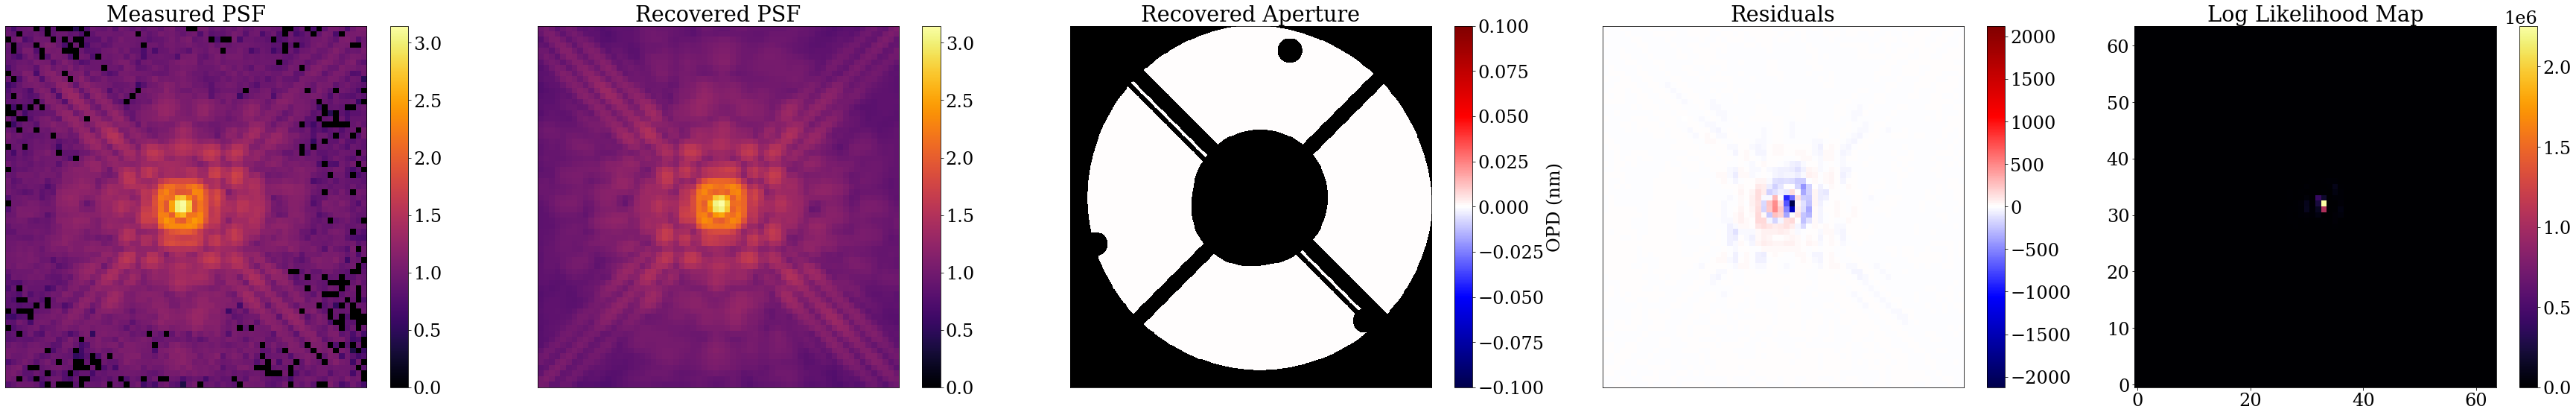

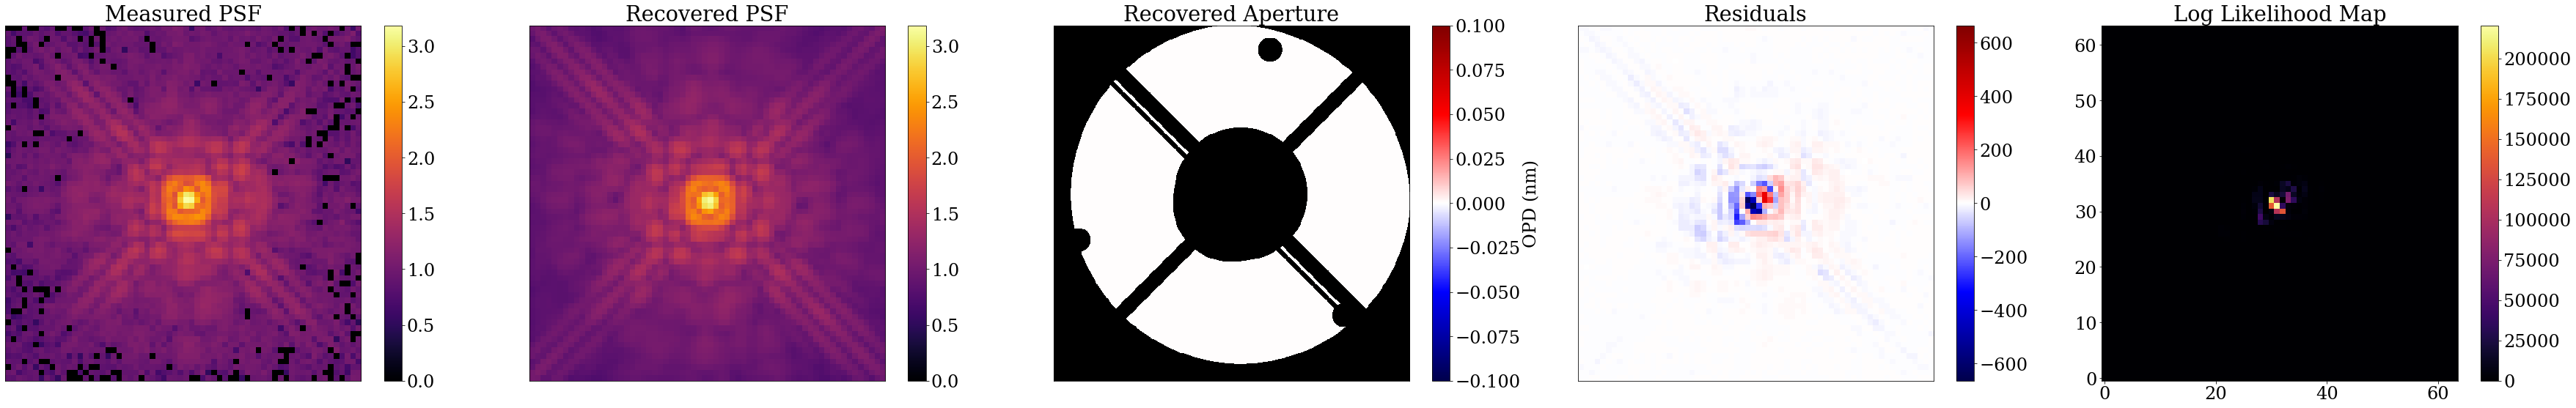

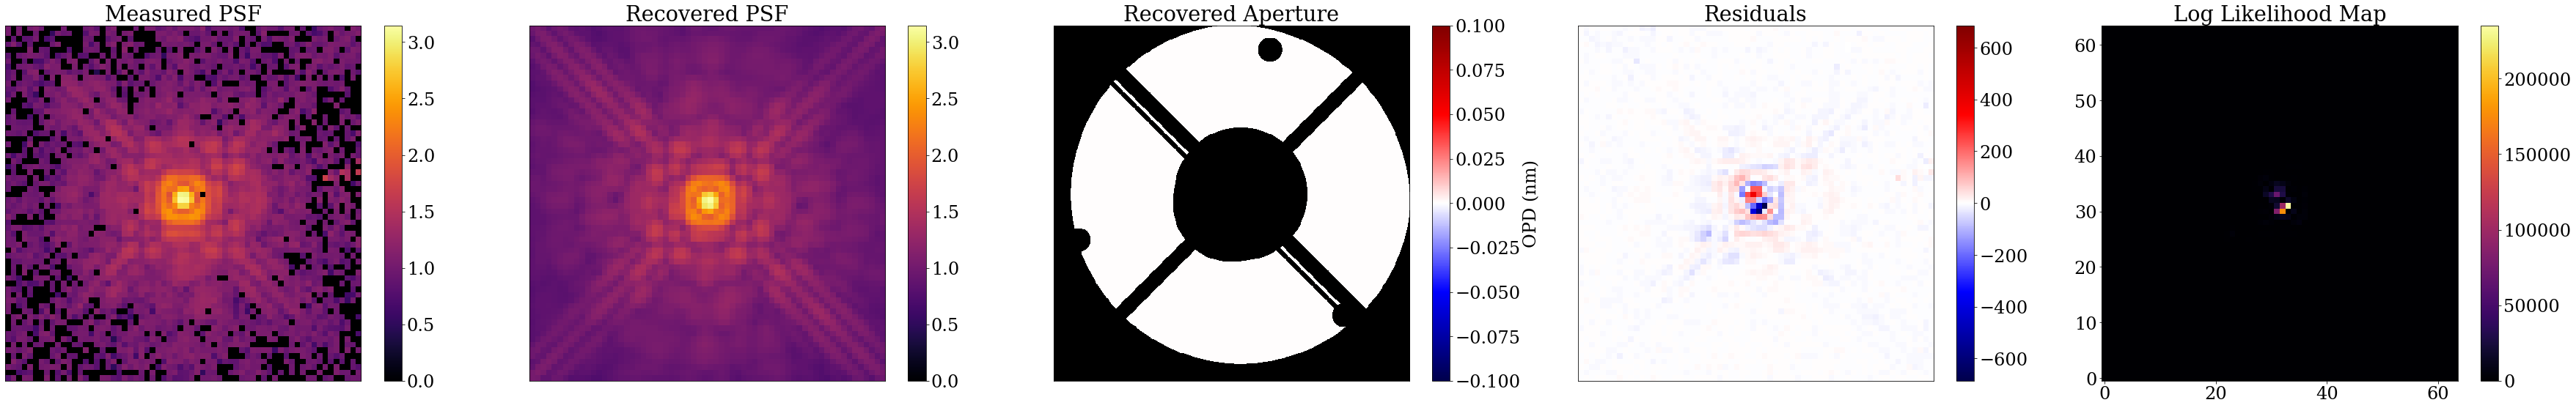

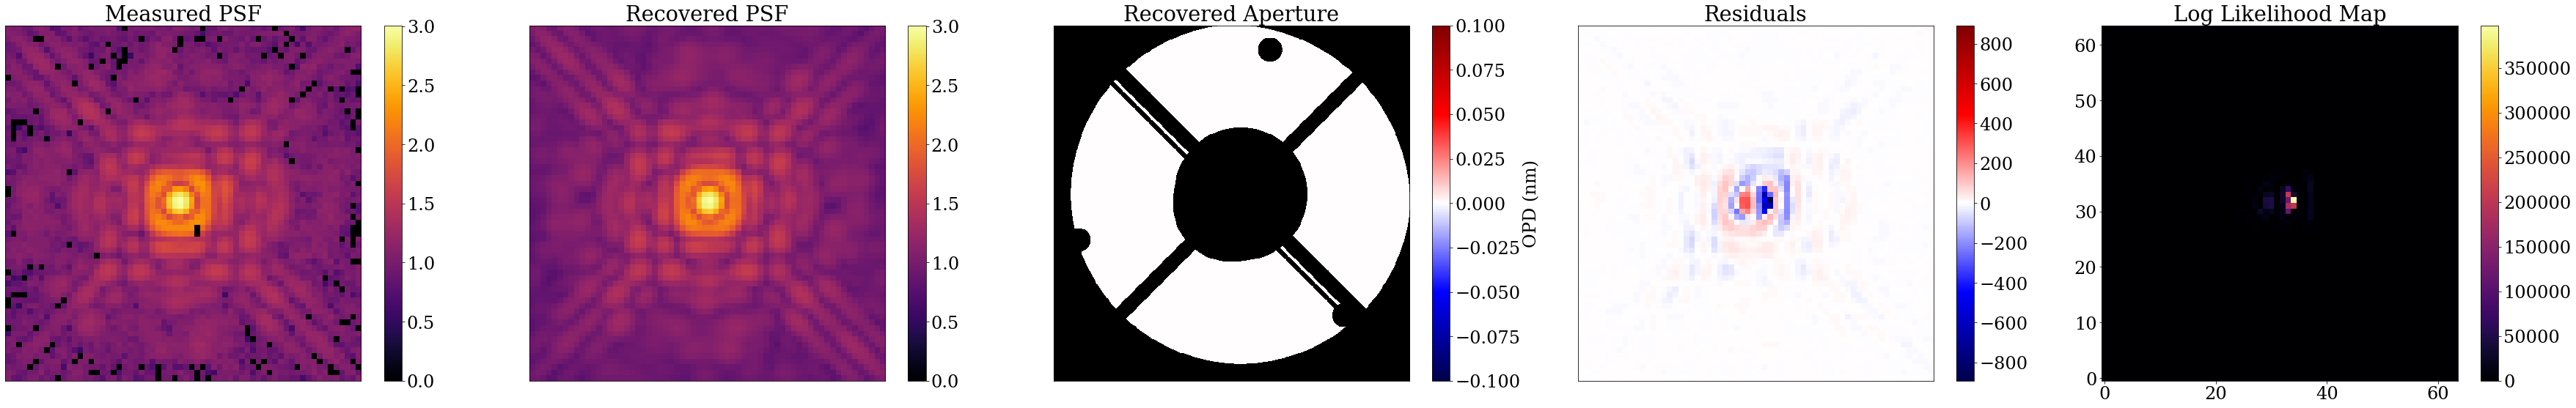

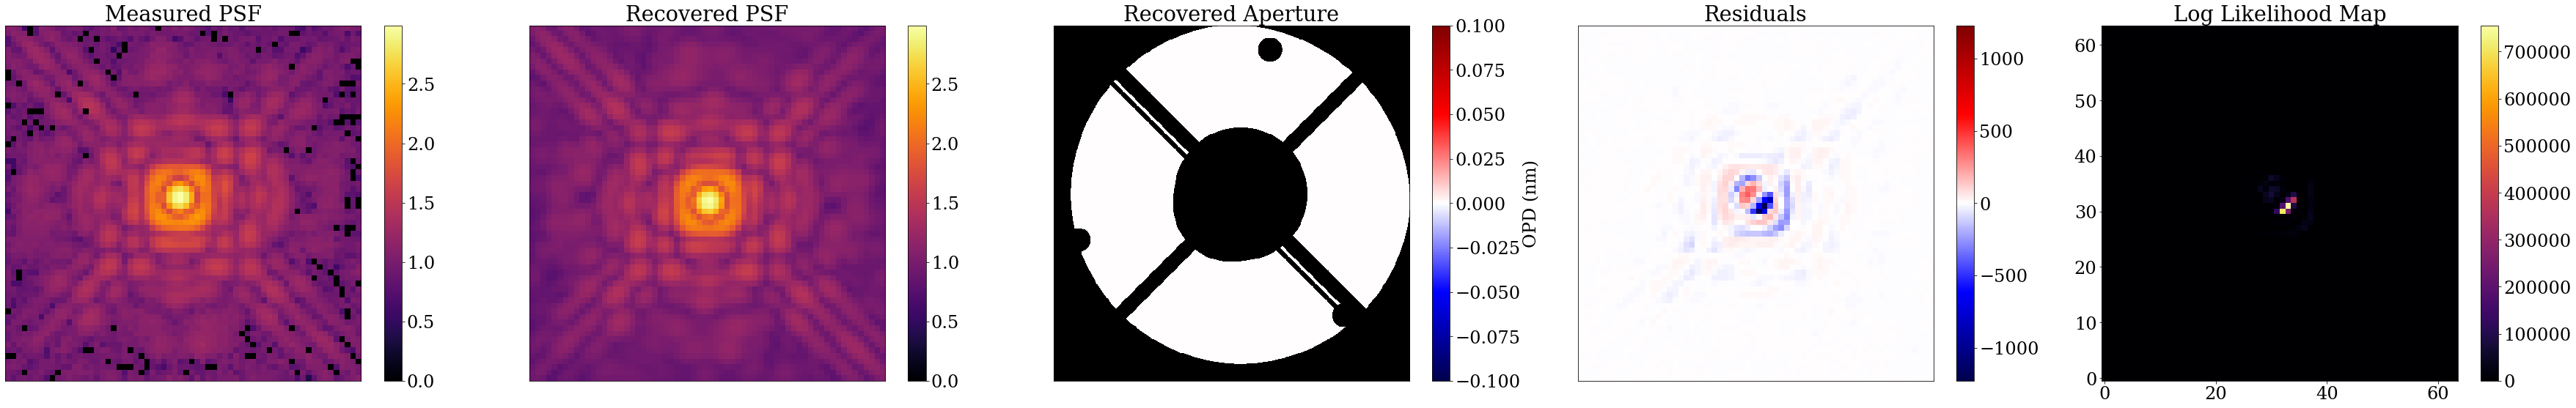

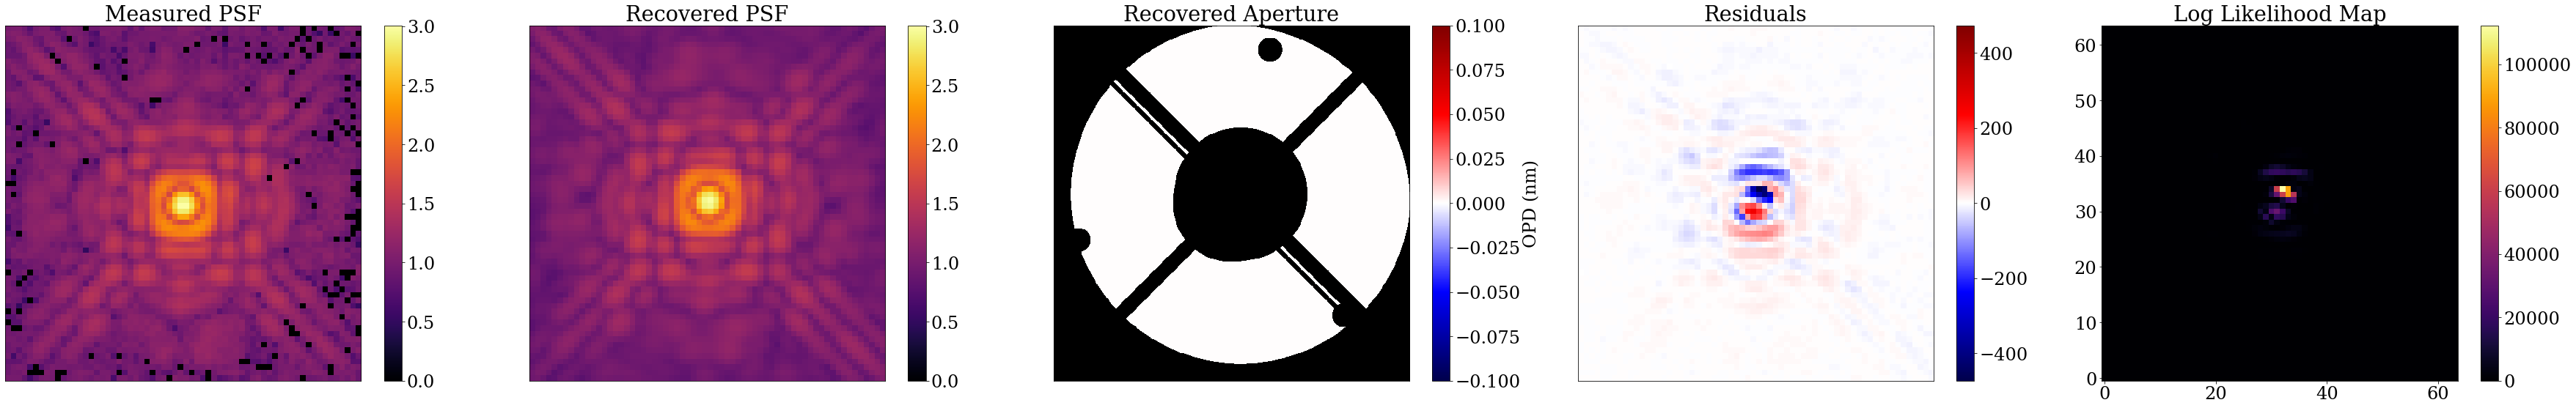

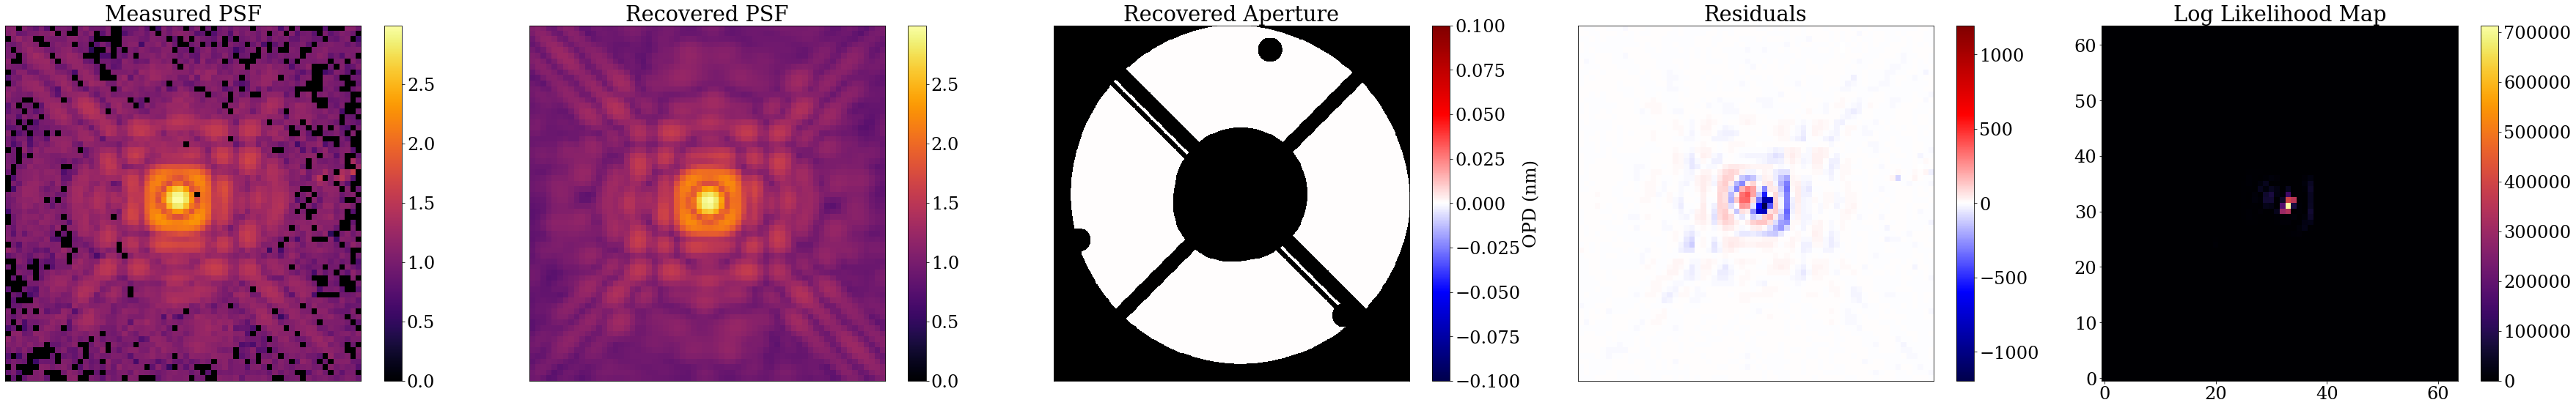

In [108]:
plot_comparison(model_single, params, exposures_single)

In [109]:
#stop

In [110]:
exposures_single[0].bad[35,60]

Array(False, dtype=bool)

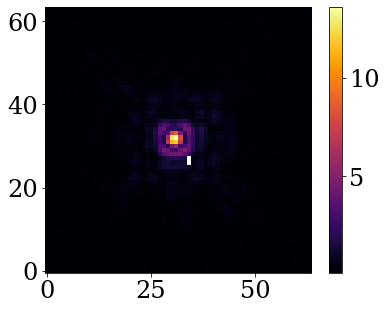

In [111]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

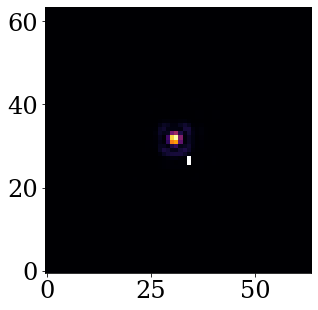

In [112]:
plt.imshow(exposures_single[0].data)

In [113]:
np.nanmin(exposures_single[0].err)

Array(0.11683887, dtype=float32)

In [114]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [115]:
loss_fn(params, exposures_single, model_single)

Array(26840302., dtype=float32)

In [116]:
#potat

In [117]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "positions": opt(g*50, 0),
    "spectrum": opt(g*80, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*200, 100),
    "cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*30, 20),
    "aberrations": opt(g*10,30),#, (80, 2)),#, (150, g*0.2)),
    #"displacement": opt(g*30, 150),
}


groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [ ]:
losses, models = optimise(params, model_single, exposures_single, things, 500)

Calculating Fishers


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'n4be02npq': {'positions': Array([[22695660. ,  -694106.4],
       [ -694106.4,  5838720. ]], dtype=float32), 'spectrum': Array([[1.4846702e+08, 5.1573500e+05],
       [5.1572750e+05, 2.4988498e+07]], dtype=float32), 'cold_mask_shift': Array([[-428120.94,   70201.36],
       [  70201.37, -438610.84]], dtype=float32), 'cold_mask_rot': Array([[-789615.8]], dtype=float32), 'bias': Array([[58902.332]], dtype=float32), 'aberrations': Array([[-3.06067688e+02, -3.34444733e+01, -9.14388428e+01,
        -7.43216782e+01,  8.29818268e+01, -3.15003986e+01,
         1.62731457e+01,  2.53426437e+01, -2.58128033e+01,
        -2.91995983e+01, -2.93246346e+01,  1.05445039e+00,
         1.20290802e+02, -1.54513306e+02,  2.70992241e+01,
         2.49665318e+01, -5.40845299e+00,  1.42648325e+01,
         2.95261719e+02,  4.51065178e+01, -2.34876957e+01,
         1.10439072e+01, -1.22940528e+00, -3.18220024e+01,
         1.29479494e+01,  5.41374207e+01],
       [-3.34439583e+01, -3.89919952e+02,  3.493981

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
losses[-1]

Array(194021.34, dtype=float32)

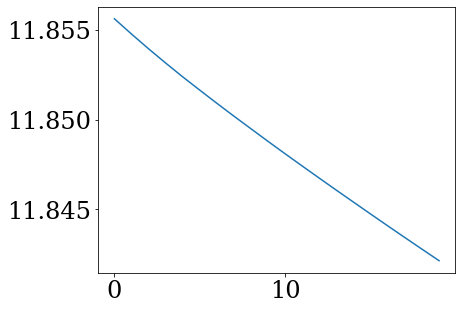

In [ ]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

6


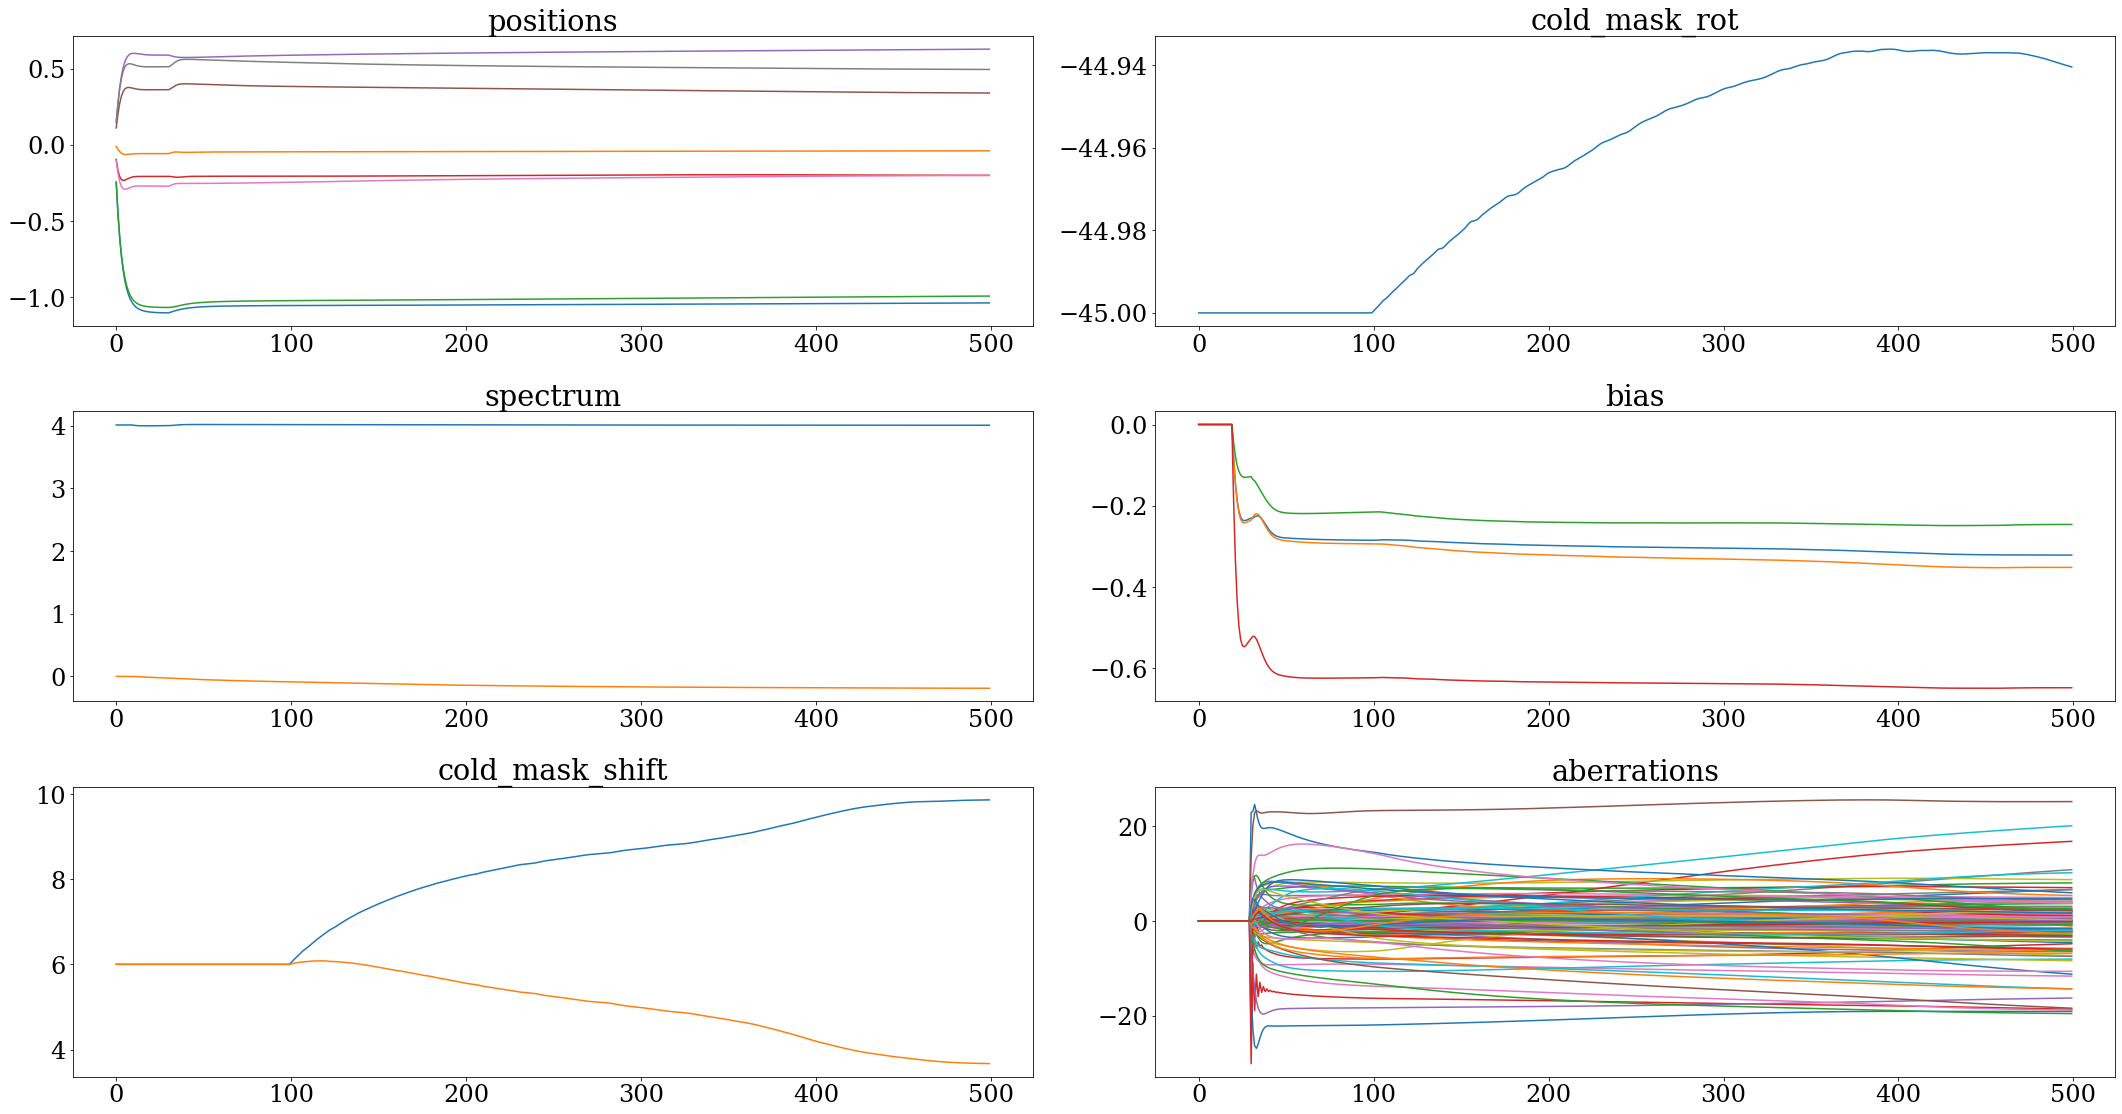

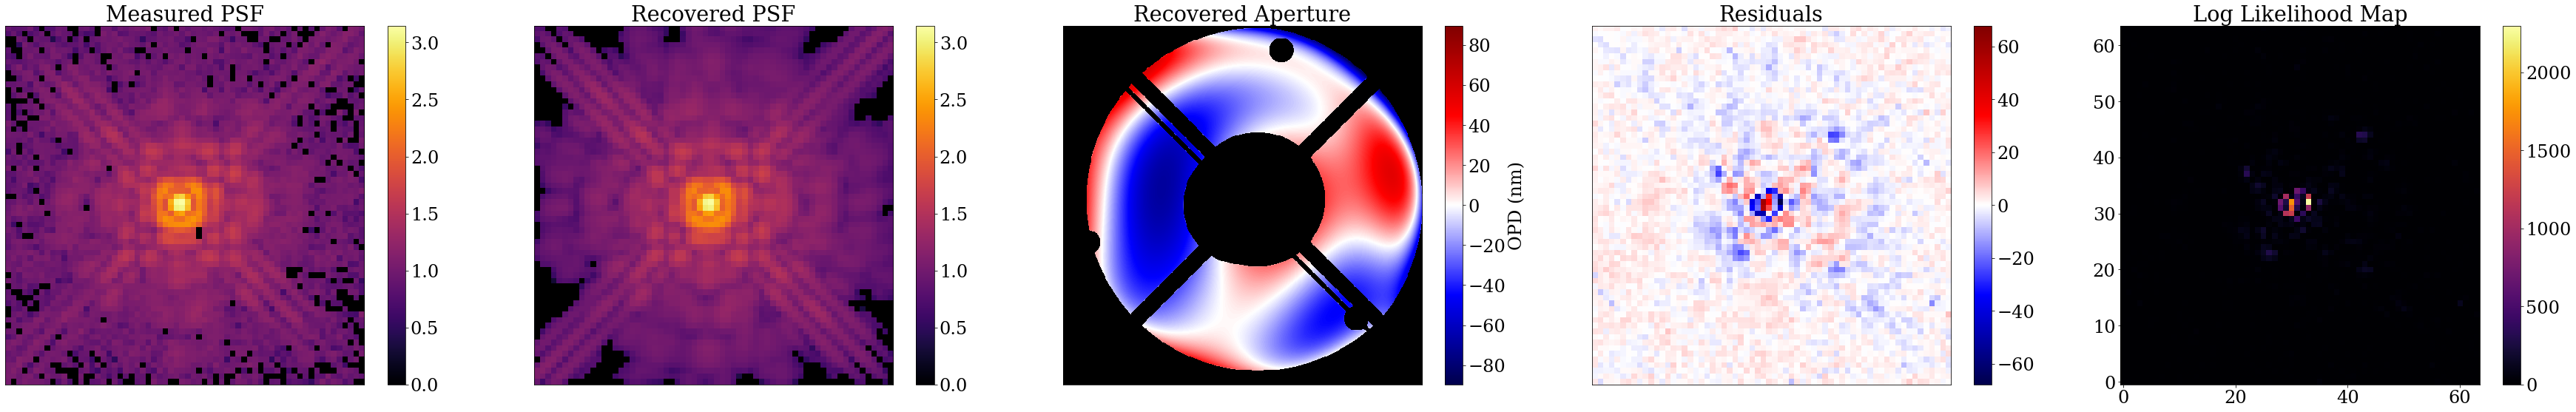

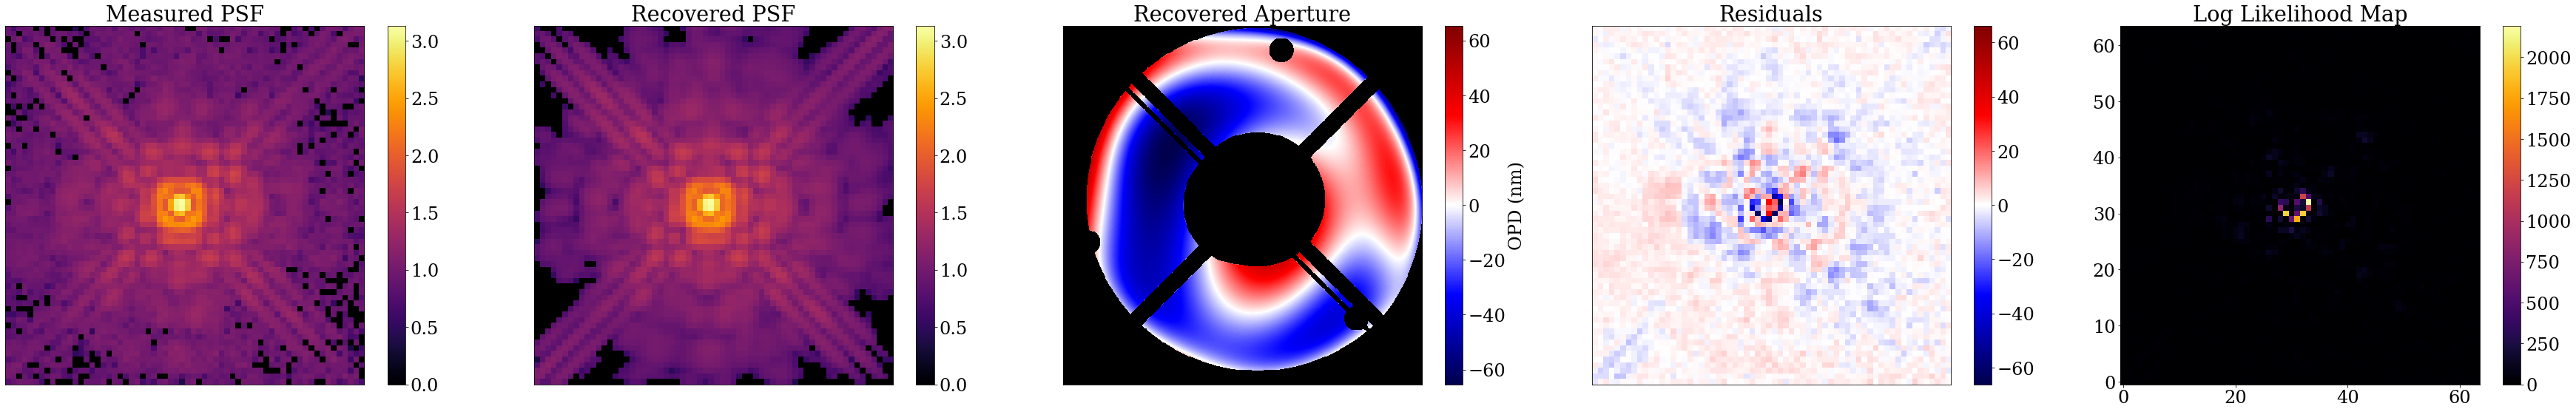

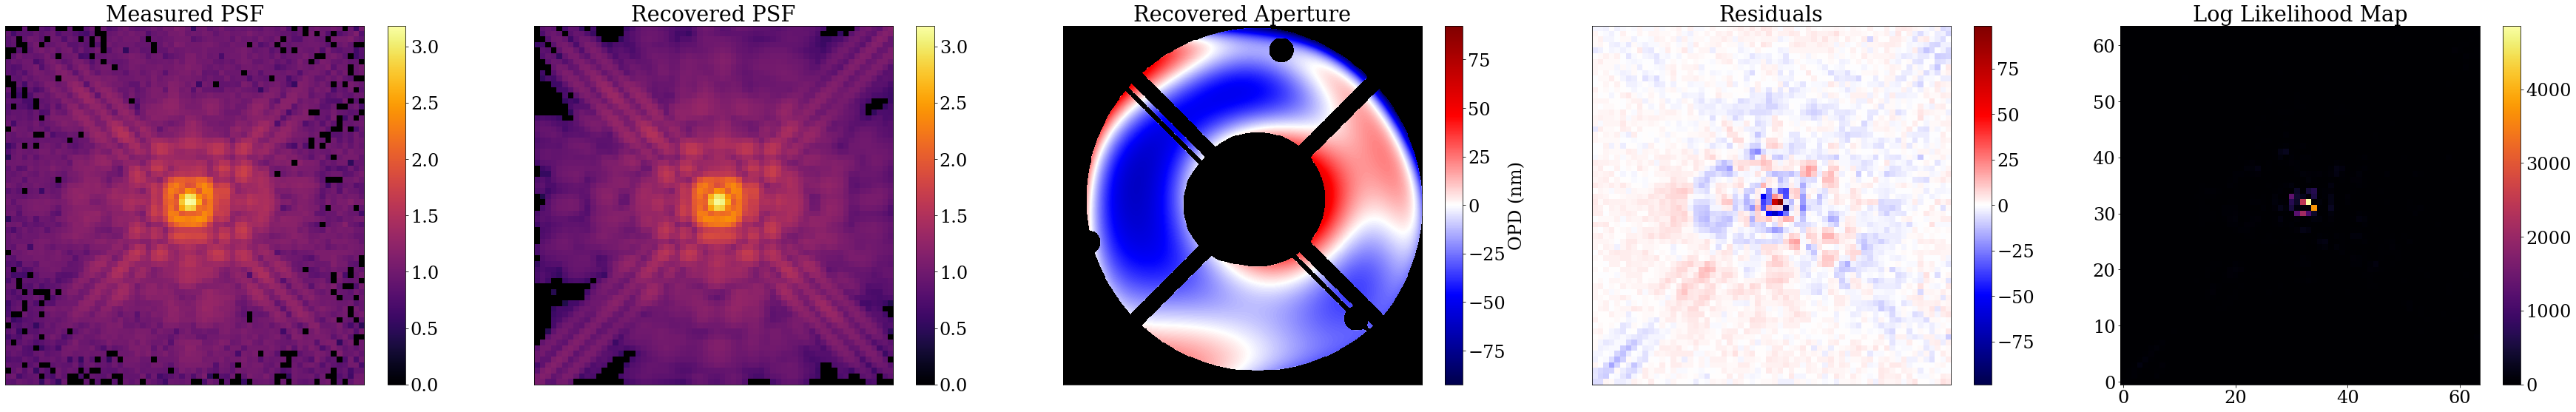

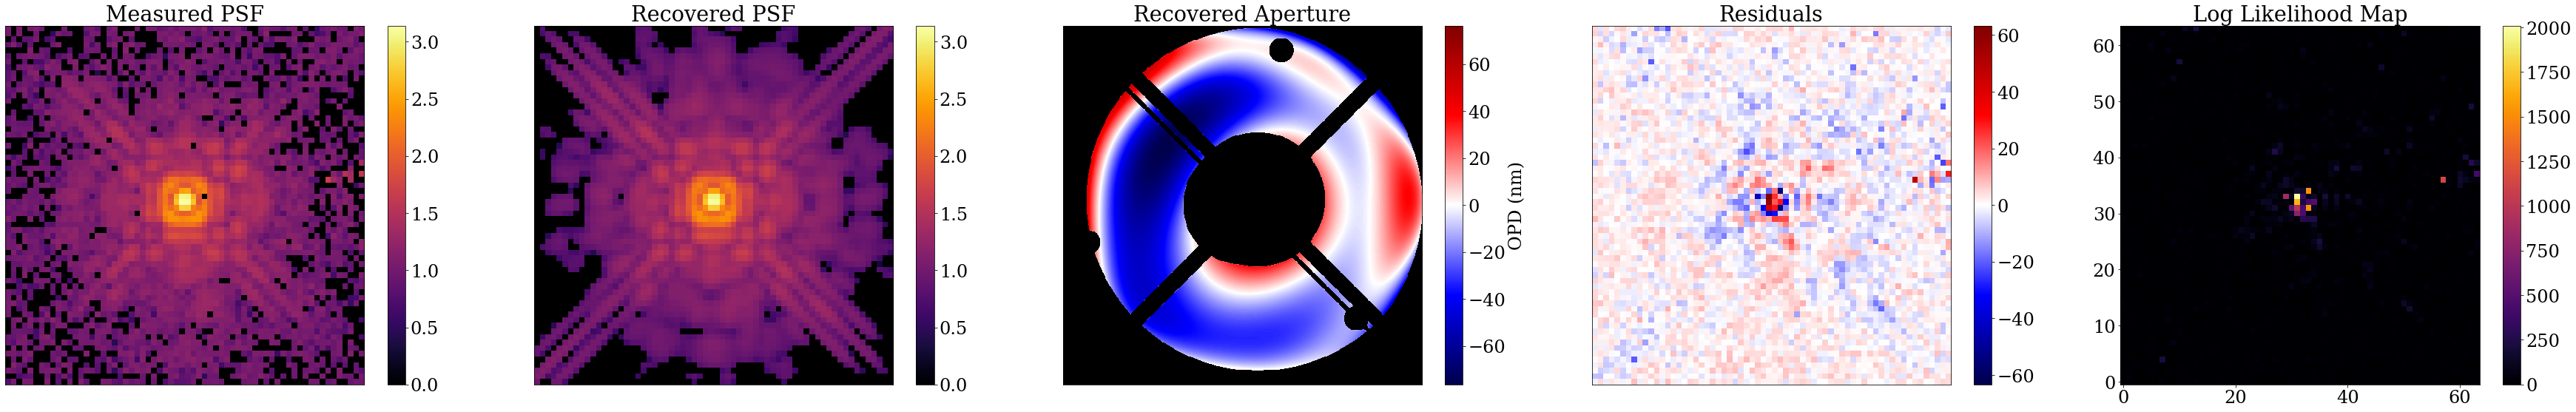

In [ ]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [ ]:
models[-1].params

{'aberrations': {'n4be02npq': Array([  6.640021  ,   2.9128847 ,  -2.7655094 , -18.660131  ,
         -16.295477  ,  -0.26789078, -11.66003   ,  10.844487  ,
           3.9313416 ,   0.98173934,  -4.590786  ,  -1.0942302 ,
           8.053174  ,  -4.8216605 ,   2.3582468 ,   0.9448283 ,
           1.0852318 ,   1.5077008 ,  -7.3037753 ,  -3.4769738 ,
           0.21313606,  -0.17619956,   3.6721835 ,  -3.128849  ,
           3.924737  ,  -5.8295546 ], dtype=float32),
  'n4be02nsq': Array([  4.9532385 ,   6.6323414 ,  -2.2435002 , -14.380248  ,
         -19.119934  ,  -2.43846   ,  -4.0321584 ,  16.832457  ,
           2.1541827 ,   2.4400792 ,  -1.4568121 ,   3.0924954 ,
           8.729176  ,  -8.065897  ,   0.13180119,   1.4269612 ,
           0.46998134,   0.13522625,  -6.4645557 ,  -2.2721386 ,
           1.2295451 ,   0.8219094 ,   3.8074417 ,  -2.2300794 ,
          -0.4037095 ,  -6.282721  ], dtype=float32),
  'n4be02nvq': Array([ -6.3972206 ,   7.039977  ,  -0.5649752 , -18.439

In [ ]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F170M", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("spectrum.LHS1846_F170M")).weights))#), yerr = spectrum_err)


KeyError: 'LHS1846_F170M'

<Figure size 720x720 with 0 Axes>

In [ ]:
no

NameError: name 'no' is not defined

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(70, dtype=int32), Array(67, dtype=int32))

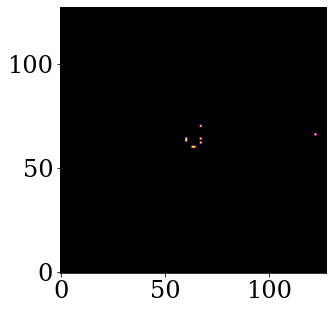

In [ ]:
plt.imshow(extra_bad)

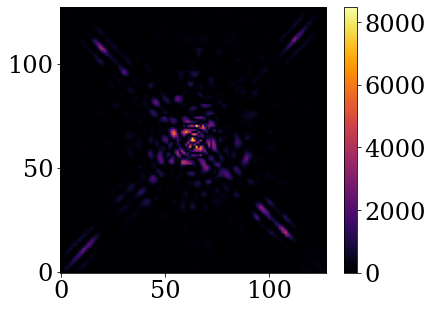

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)